# Analyse hydrofoil

In [1]:
# Import modules
import numpy as np
import AXIS_wing_definitions as AX_wings
from foilpy.foildef import FoilAssembly
from foilpy.LL_functions import steady_LL_solve
from foilpy.analysis import plot_wake
from foilpy.utils import knts2ms, ms2knts
%matplotlib widget

### Define speed and reynolds number

In [2]:
# Seawater properties: https://www.engineeringtoolbox.com/sea-water-properties-d_840.html
# Assumes 15 deg temperature seawater
speed_knts = 15
speed_ms = knts2ms(speed_knts)
chord = 0.2 # meters
rho = 1026
re = speed_ms * chord * rho / 0.00126
print("Reynolds number = ", str(re), "\n")

# Define simple motion vector, moving forward in y
u_motion = np.array([0, speed_ms, 0]).reshape(1, 3)
print("Input velocity vector = ", str(u_motion), " m/s (= ", str(ms2knts(u_motion)), " knots)\n ")


Reynolds number =  1256714.6040819855 

Input velocity vector =  [[0.         7.71666862 0.        ]]  m/s (=  [[ 0. 15.  0.]]  knots)
 


### Define wings
Use templates for some of the AXIS components. Note, these are approximations/guesses at the real geometries.

Projected wing area is  1022.2054223294302  cm^2
Aspect ratio is  6.418475050786379
Projected wing area is  1022.2054223294302  cm^2


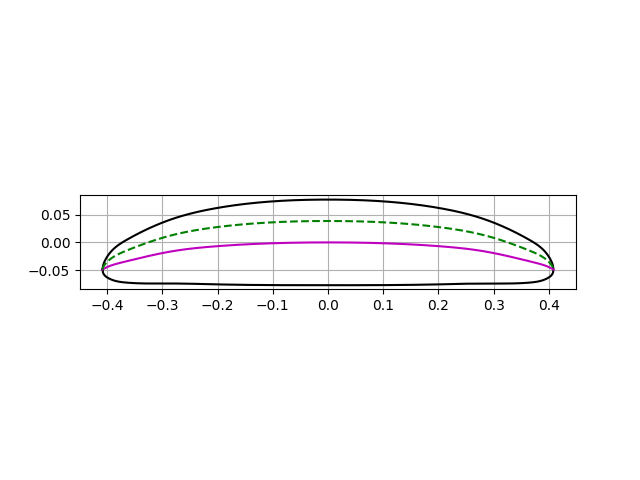

Total mass (without rider) =  8.631 

Total mass (including rider) =  83.631 

CoG location =  [[0.        ]
 [0.42092131]
 [0.7814955 ]] 



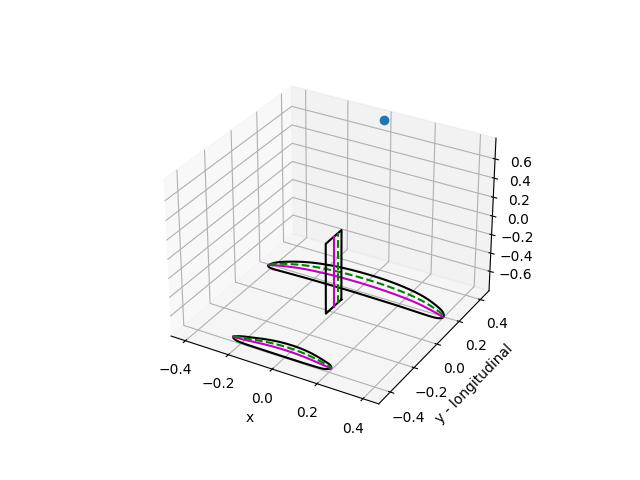

(<Figure size 640x480 with 1 Axes>,
 <Axes3DSubplot:xlabel='x', ylabel='y - longitudinal'>)

In [3]:
# Define front wing
front_wing = AX_wings.bsc_810(re, nsegs=40, plot_flag=False)
front_wing.plot2D()

# Define stabiliser
stab = AX_wings.stab_fr_440(re, nsegs=40, plot_flag=False)

# Define mast
mast = AX_wings.mast_75cm(re, nsegs=8, plot_flag=False)

# Assemble foil
foil = FoilAssembly(front_wing,
                    stab,
                    mast,
                    fuselage_length=699 - 45 - 45,  # assumes AXIS short black fuselage
                    mast_attachment_ratio=267 - 45,  # assumes AXIS short black fuselage
                    wing_angle=1,
                    stabiliser_angle=-2,
                    units='mm')

foil.plot_foil_assembly()

### Analyse hydrofoil at a single speed/orientation

In [4]:
# pitch the foil by 2 degrees to generate some lift
foil.rotate_foil_assembly([2, 0, 0]) 
# compile relevant foil data into a list of dictionaries
lifting_surfaces = foil.surface2dict()

# run steady lifting line solver
out = steady_LL_solve(lifting_surfaces, # foil properties
                      -u_motion,        # relative flow speed
                      rho,              # fluid density
                      dt=0.05,          # initial (pseudo) time step
                      nit=30,           # max number of iterations
                      wake_rollup=True, # determines whether induced flow convects wake or not
                      variable_time_step=False)

Steady aero solve    -    time step  0     -    d_gamma =  0.5361228585243225
Steady aero solve    -    time step  5     -    d_gamma =  0.07739260792732239
Steady aero solve    -    time step  10     -    d_gamma =  0.0017501263646408916
Steady aero solve    -    time step  15     -    d_gamma =  4.488964259508066e-05
Steady aero solve    -    time step  20     -    d_gamma =  1.6460644474136643e-05
Ending steady loop due to convergence of bound circulation (gamma).


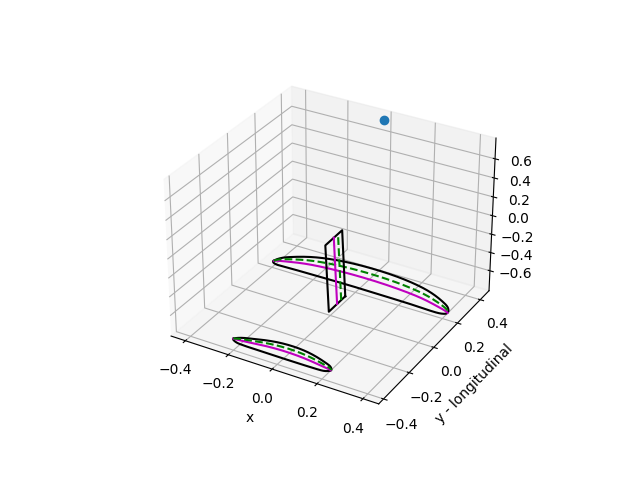

In [5]:
# plot foil and wake
wake_elmt_table = out[3]
elmtIDs = out[5]
plot_wake(foil, lifting_surfaces, wake_elmt_table, elmtIDs)

In [10]:
# print loading generated by hydrofoil
u_cp = out[0]
load = foil.compute_foil_loads(-u_motion, rho, u_cp)
print(load)
print("The foil produces", str(load[2]), "N of lift,", str(-load[1]), "N of drag, and", str(load[3]), "Nm of pitching moment.")

[ 4.55277037e-06 -5.57583659e+01  9.38197144e+02 -1.06625011e+02
 -1.33766584e-05  5.92115834e-07]
The foil produces 938.1971435546875 N of lift, 55.75836587595997 N of drag, and -106.62501124129349 Nm of pitching moment.


### Analyse hydrofoil (without wake rollup)

In [11]:
out1 = steady_LL_solve(lifting_surfaces, # foil properties
                      -u_motion,        # relative flow speed
                      rho,              # fluid density
                      dt=0.05,          # initial (pseudo) time step
                      nit=30,           # max number of iterations
                      wake_rollup=False,# determins whether induced flow affects wake or not
                      variable_time_step=False)
u_cp = out1[0]
load1 = foil.compute_foil_loads(-u_motion, rho, u_cp)
print(load1)
print("The foil produces", str(load1[2]), "N of lift,", str(-load1[1]), "N of drag, and", str(load1[3]), "Nm of pitching moment.")   

Steady aero solve    -    time step  0     -    d_gamma =  0.5361228585243225
Steady aero solve    -    time step  5     -    d_gamma =  0.07045878469944
Steady aero solve    -    time step  10     -    d_gamma =  0.0016014776192605495
Steady aero solve    -    time step  15     -    d_gamma =  4.537373024504632e-05
Steady aero solve    -    time step  20     -    d_gamma =  1.6799638615339063e-05
Ending steady loop due to convergence of bound circulation (gamma).
[ 4.69852235e-06 -5.56444552e+01  9.35945312e+02 -1.04700674e+02
 -8.80887890e-06  7.32779644e-07]
The foil produces 935.9453125 N of lift, 55.64445520091114 N of drag, and -104.70067363586311 Nm of pitching moment.


It can be seen wake rollup has minimal effect on the gloal forces/moments generated by this specific hydrofoil assembly, with the given speed/orientation.